# Graph Theoretical Analysis

In [3]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import plotly
import plotly.figure_factory as ff
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.style as style
import networkx as nx
import matplotlib.pyplot as plt
import SigProc
import analysis_utils as au

from scipy import stats
from plotly import tools
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, Math, Latex

InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [4]:
TRACE_RAW_DRD87 = "/Users/saveliyyusufov/Hen_Lab/Mice/drd87_experiments/Raw_EPM_drd87.csv"
data = pd.read_csv(TRACE_RAW_DRD87, header=None)
z_scored_dataframe, AUC_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)

## Now, we plot an undirected graph of the network of cells that were imaged for a given mouse
- Edges are added between pairs of neurons that had a correlation coefficient $\ge 3.0$
    - Each edge is weighted by the correlation coefficient corresponding to the two neurons it connects
    - The correlation coefficient between each corresponding pair of neurons is drawn on the edge between them
    - The color of each edge is determined by the correlation between the pair of neurons: 
        - yellow - correlated
        - green - strongly correlated 
        - blue - very strongly correlated
- Isolate nodes are also plotted
- No clustering algorithm was applied to this network of nodes... the graph drawing algorithm that was utilized keeps corresponding nodes clustered together by accounting for the weights of the edges
- Note that the clusters of nodes strongly correspond to the clusters created by the Seaborn library's cluster map data visualization

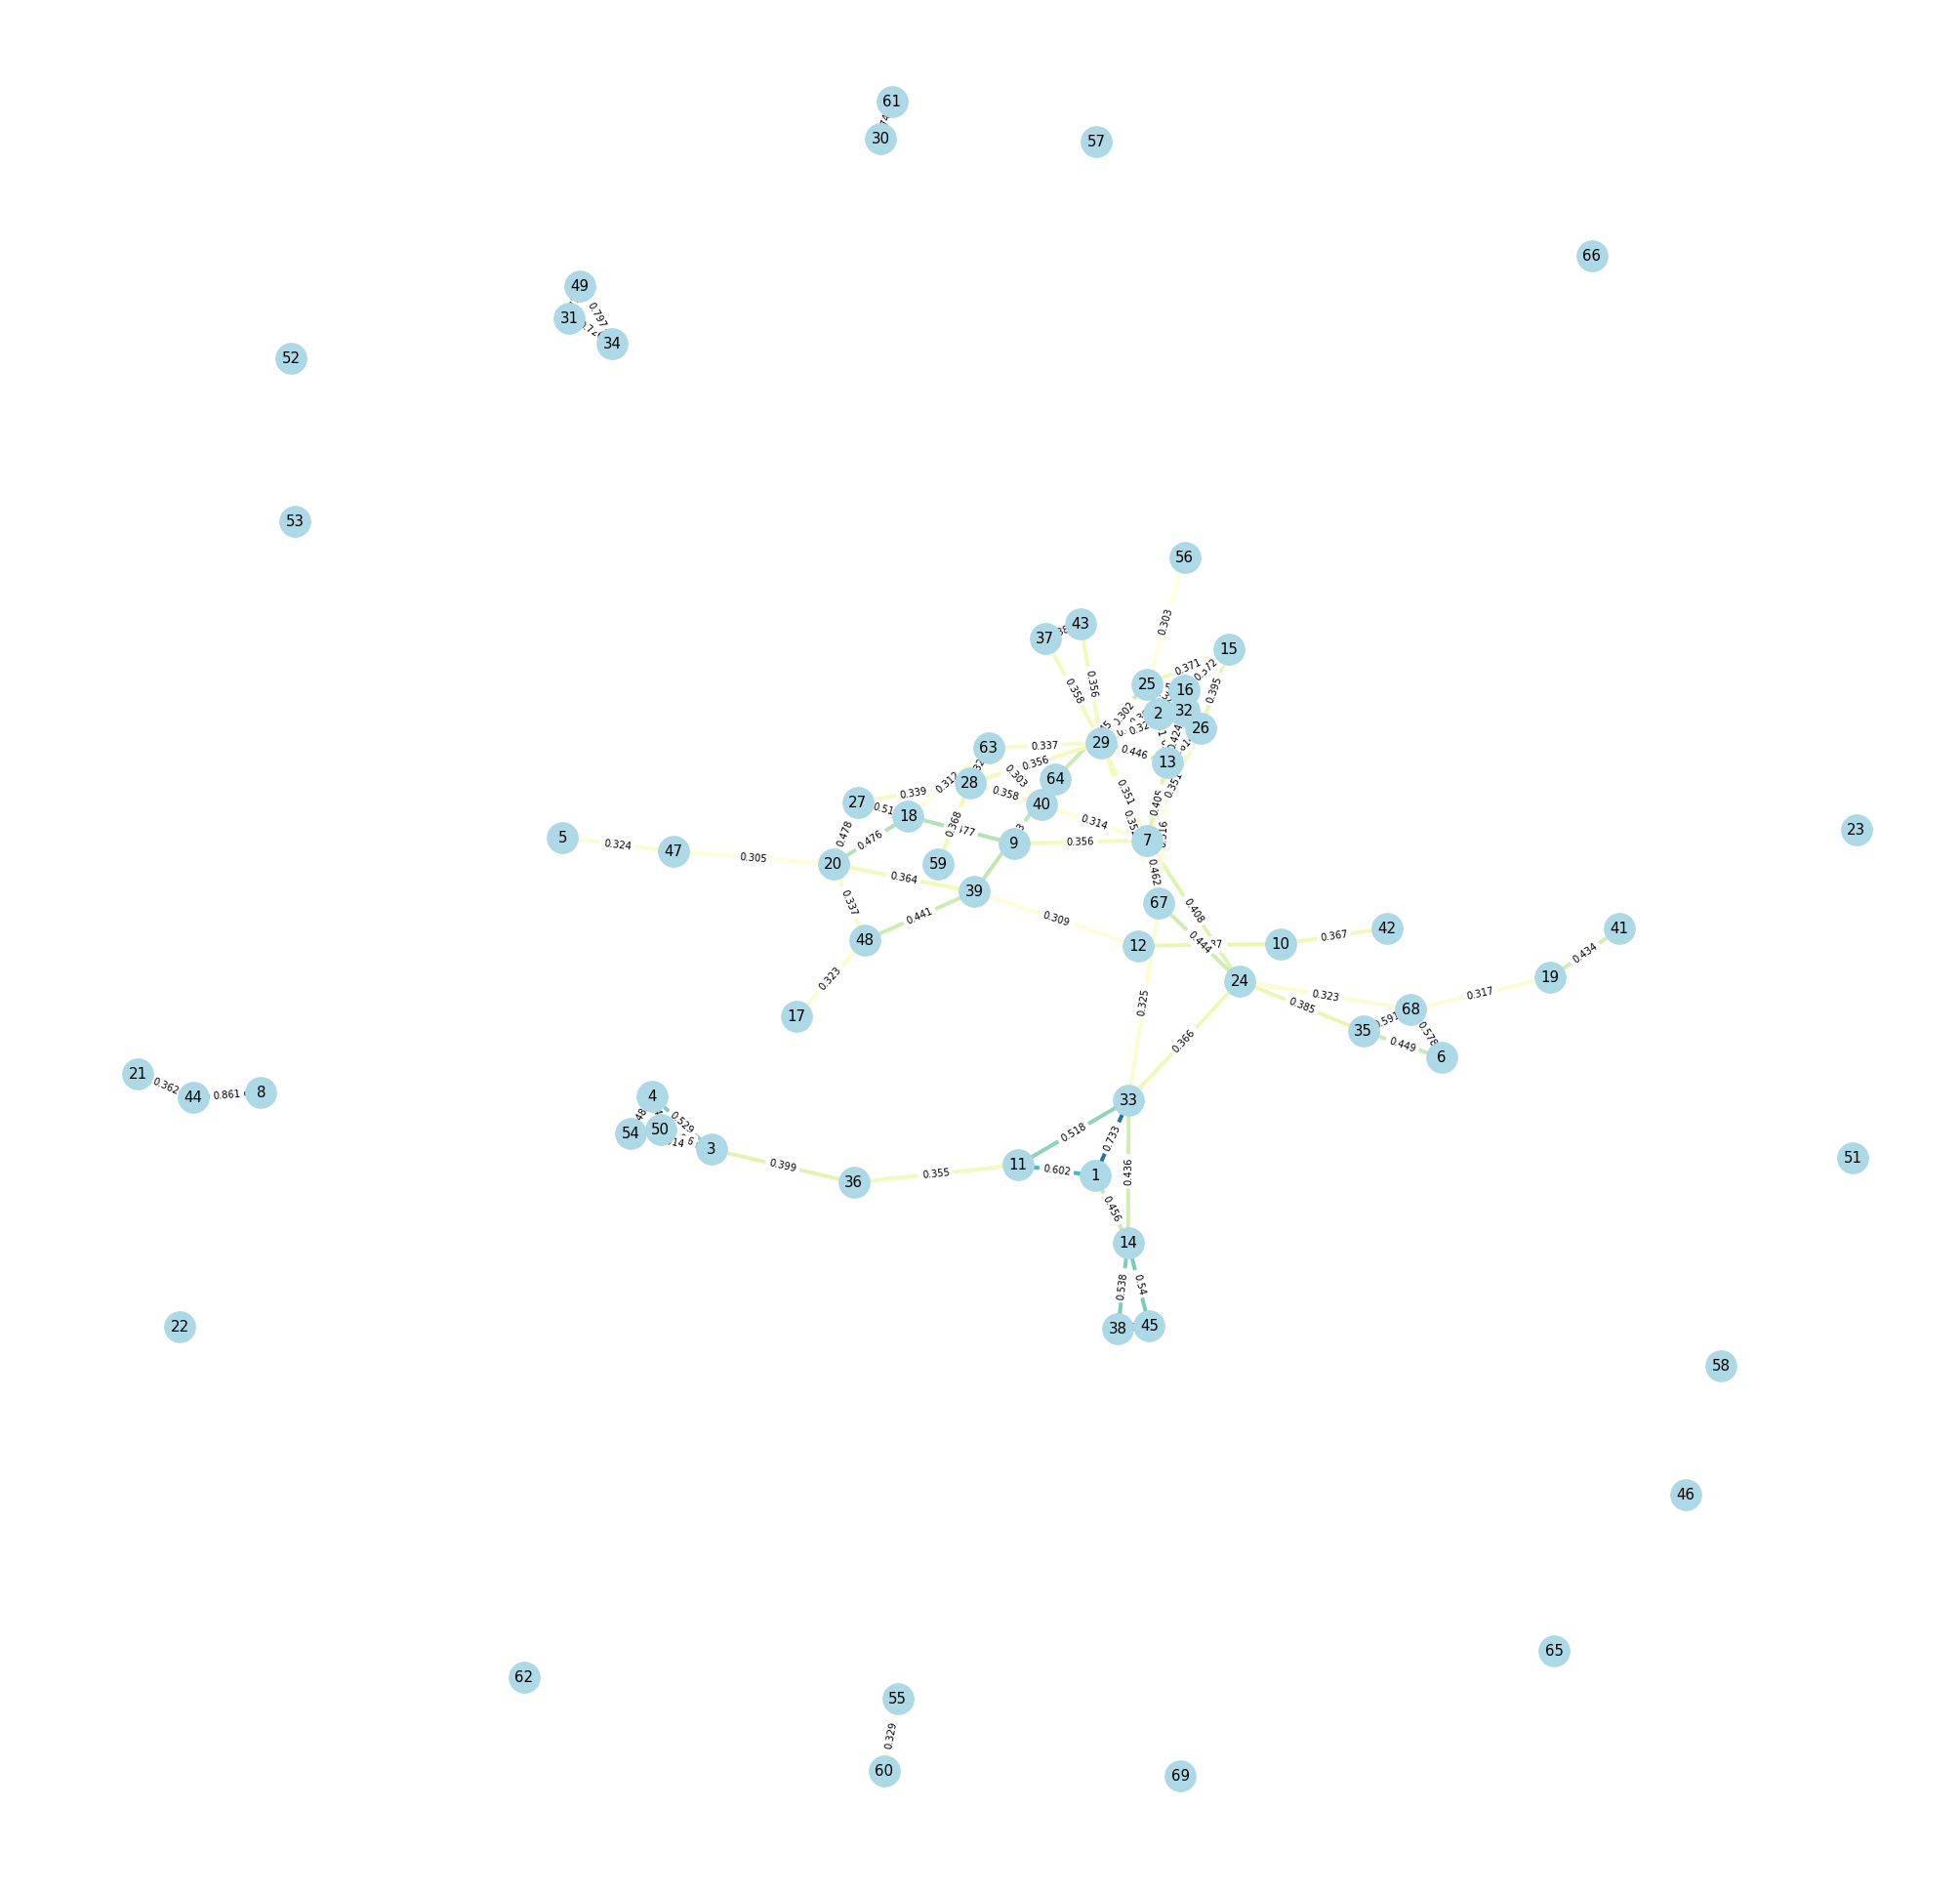

In [5]:
G = nx.Graph()

cell_transients_dataframe.columns = [i for i in range(1, len(cell_transients_dataframe.columns)+1)]
G.add_nodes_from(cell_transients_dataframe.columns)

correlated_pairs_dict = au.find_correlated_pairs(cell_transients_dataframe, correlation_coeff=0.3)

for key in correlated_pairs_dict:
    G.add_edge(key[0], key[1], weight=round(correlated_pairs_dict[key], 3))
        
# positions for all nodes
pos = nx.spring_layout(G, weight='weight') 

plt.figure(figsize=(35, 35))

# nodes
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue');

edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

# edges
nx.draw_networkx_edges(G, pos, width=4.0, edge_color=weights, edge_cmap=plt.cm.YlGnBu);

labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# labels
nx.draw_networkx_labels(G, pos, font_size=15, edge_labels=labels)

plt.axis('off');
plt.savefig("drd87_Network_Graph.png", format="PNG")
plt.show();

## The degree of a node is the number of edges that link it to the rest of the network. According to Bullmore et al. 2009, node degree is the most fundamental network measure, and most other measures are ultimately linked to node degree. 
### So, we output a dictionary that contains each node (neuron) in the network and its corresponding degree
- For the sake of curiosity, we retrieve the name of the node that has the greatest degree in this particular network
    - As we can see, in the case of the dataset for drd87, the degree of node (neuron) $29$ is $11$, and this is the largest degree of any node for this particular network

In [6]:
max(dict(G.degree()), key=dict(G.degree()).get)

29

## A simple bar plot that depicts the degree of each node (neuron) in the network
- Using this plot, we can see that node $29$ does indeed have the highest degree

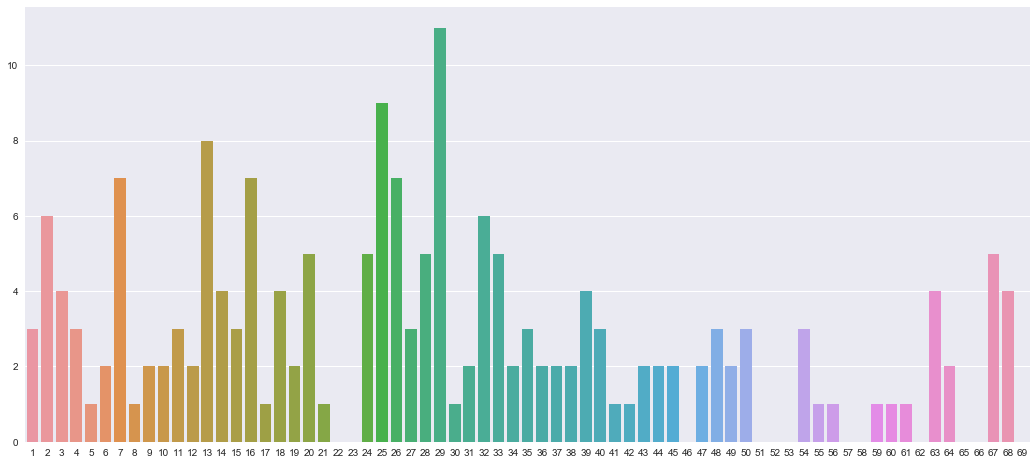

In [7]:
sns.set(rc={"figure.figsize": (18, 8)})
sns.barplot(x=list(dict(G.degree()).keys()), y=list(dict(G.degree()).values()));

In [8]:
len(G.edges)
sum(list(dict(G.degree()).values()))

92

184

## According to Bullmore et al. 2009, in random networks, all connections are equally probable, resulting in a Gaussian degree distribution. In complex networks, the degree distributions are non-Gaussian, and often have a long tail towards high degrees. 
### So, we plot the distribution of the degrees of all the nodes (neurons) in our network

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



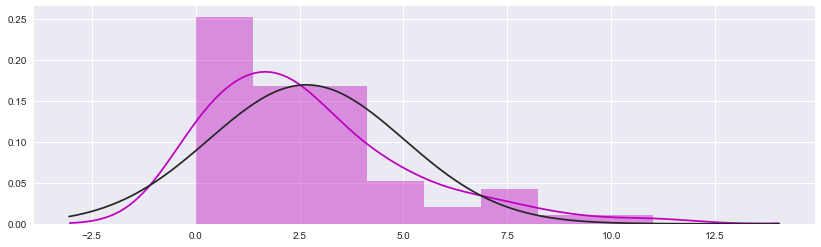

In [9]:
sns.set(rc={"figure.figsize": (14, 4)})
sns.distplot(list(dict(G.degree()).values()), color='m', fit=stats.norm);

## Next, we compute the centrality in this network using the Katz centrality algorithm (already implemented in the NetworkX library)
### Note, the default attenuation factor was not changed to the actual attenuation factor for this particular network. In the future the attenuation factor will be found by taking the max eigenvalue of the adjacency matrix that represents our network, and computing: $$\alpha < \frac{1}{\lambda_{max}}$$

In [10]:
centrality = nx.katz_centrality(G)

In [11]:
# TODO: Fix this to use this to compute attenuation factor
# adj_matrix = nx.adj_matrix(G)
# np.linalg.eig(adj_matrix)

## Using the Katz centrality algorithm, we find that node (neuron) 29 has the highest centrality in this network
### Hubs are nodes with high degree, or high centrality. The centrality of a node measures how many of the shortest paths between all other node pairs in the network pass through it. A node with high centrality is thus crucial to efficient communication (Bullmore et al. 2009)
### Going off of this, we can assume that node (neuron) 29 is a hub in this partricular network.

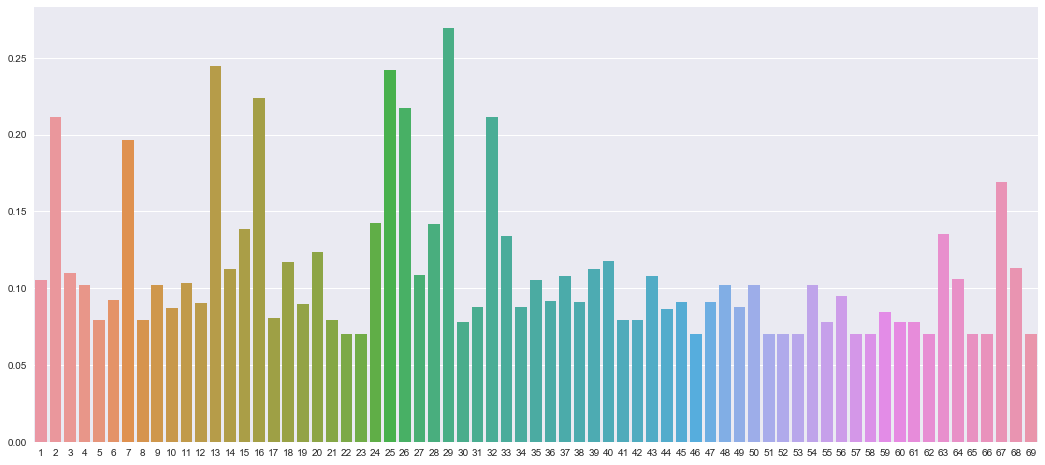

In [12]:
centrality_values = {n:c for n, c in sorted(centrality.items())}
sns.set(rc={"figure.figsize": (18, 8)})
sns.barplot(x=list(centrality_values.keys()), y=list(centrality_values.values()));

In [13]:
max(centrality_values, key=centrality_values.get)

29

## In accordance with Bullmore et al. 2009, our network measures must be compared with the (null) distribution of equivalent parameters estimated in random networks containing the same number of nodes and connections. 
> "Statistical testing of network parameters may best be conducted by permutation- or resampling-based methods of non-parametric inference given the lack of statistical theory concerning the distribution of most network metrics." (Bullmore et al. 2009)

## So, we begin by plotting an undirected graph of the $69$ nodes (neurons) from our dataset and we draw $184$ edges between $92$ (the amount of correlated neurons in our dataset) randomly selected pairs of nodes.

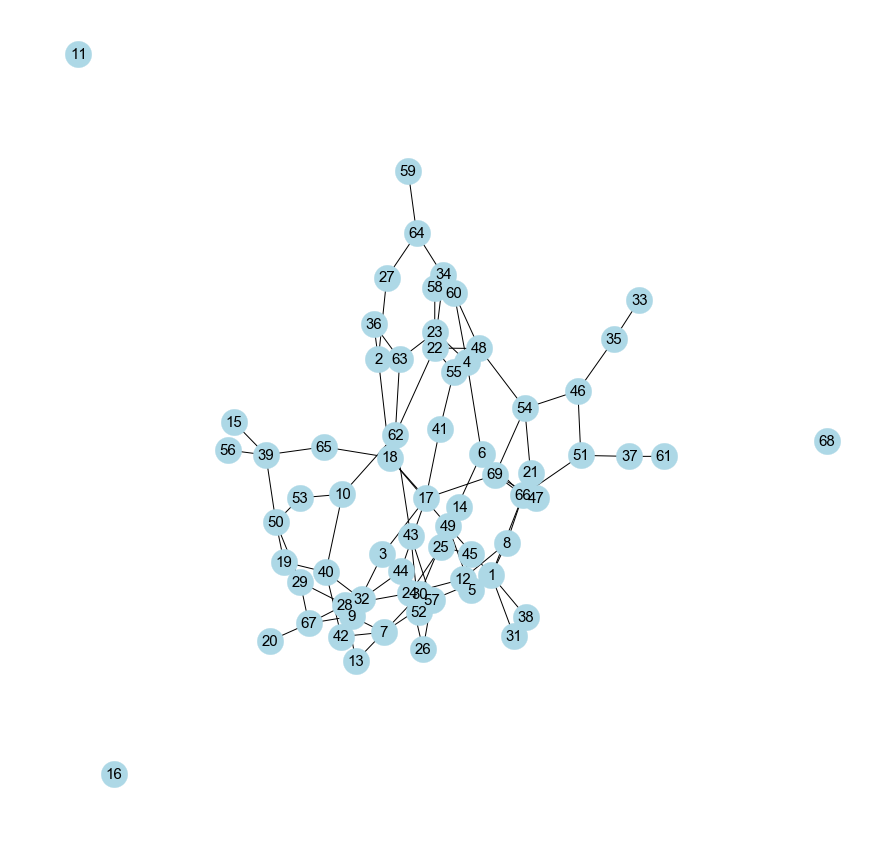

In [14]:
G_2 = nx.Graph()

G_2.add_nodes_from(cell_transients_dataframe.columns)

# Connect an len(correlated_pairs_dict) amount of random edges between all the nodes in the random graph
for i in range(len(correlated_pairs_dict)):
    G_2.add_edge(np.random.randint(1, len(cell_transients_dataframe.columns)+1), np.random.randint(1, len(cell_transients_dataframe.columns)+1))
    
# positions for all nodes
pos = nx.spring_layout(G_2, weight='weight') 

plt.figure(figsize=(15, 15))

# nodes
nx.draw_networkx_nodes(G_2, pos, node_size=700, node_color='lightblue');

#edges, weights = zip(*nx.get_edge_attributes(G_2, 'weight').items())

# edges
nx.draw_networkx_edges(G_2, pos, width=1.0); 

labels = nx.get_edge_attributes(G_2, 'weight')
nx.draw_networkx_edge_labels(G_2, pos, edge_labels=labels)

# labels
nx.draw_networkx_labels(G_2, pos, font_size=15, edge_labels=labels)

plt.axis('off');
plt.show();

## We quickly plot a degree distribution plot for this random network to see if it is Gaussian 
- recall that a random network should have Gaussian degree distribution

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



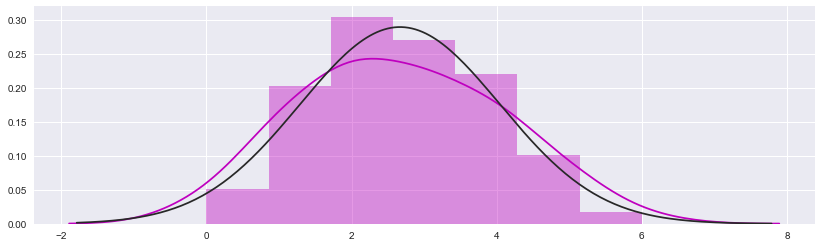

In [16]:
sns.set(rc={"figure.figsize": (14, 4)})
sns.distplot(list(dict(G_2.degree()).values()), color='m', fit=stats.norm);

## We compute the Katz centrality of this random network

In [17]:
centrality = nx.katz_centrality(G_2)
centrality_values = {n:c for n, c in sorted(centrality.items())}
max(centrality_values, key=centrality_values.get)

1

In [18]:
behavior_column_names = ['Trial_time', 'Recording_time', 'X_center', 'Y_center', 'Area', 'Areachange', 
                         'Elongation', 'Distance_moved', 'Velocity', 'Arena_centerpoint',
                         'Open1_centerpoint', 'Open2_centerpoint',
                         'Closed1_centerpoint', 'Closed2_centerpoint',
                         'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Result_1']

activity_df = pd.read_csv('/Users/saveliyyusufov/Hen_Lab/Mice/drd87_experiments/activity_drd87.csv', header=None)
behavior_df = pd.read_csv('/Users/saveliyyusufov/Hen_Lab/Mice/drd87_experiments/behavior_drd87.csv', header=None)

# Save only every nth row in order to downsample behavior Dataframes from 30fps -> 10fps
ROW_MULTIPLE = 3
behavior_df.drop(behavior_df.index[[i for i in range(0, len(behavior_df.index)) if i % ROW_MULTIPLE != 0]], inplace=True)

# For the activity Dataframe, we Change column names to corresponding neuron names 
activity_df.columns = ['neuron' + str(i) for i in range(1, len(activity_df.columns) + 1)]

# Change column names to the behavior column names found in the MossyEPM, MATLAB struct
behavior_df.columns = behavior_column_names

# Fix indexing after downsample
behavior_df.reset_index(drop=True, inplace=True)

# Make the behavior Dataframe and the activity Dataframe have the same amount of rows 
if len(behavior_df.index) > len(activity_df.index):
    diff = len(behavior_df.index) - len(activity_df.index)
    behavior_df = behavior_df[:-diff]
elif len(behavior_df.index) < len(activity_df.index):
    diff = len(activity_df.index) - len(behavior_df.index)
    activity_df = activity_df[:-diff]

# Define running frames
VELOCITY_CUTOFF = 4;

# Adds column to the end of the behavior Dataframe and make each cell in that column a 0 
# if the corresponding velocity < VELOCITY_CUTOFF or a 1 if the corresponding velocity >= VELOCITY_CUTOFF
# TODO: Utilize a pandas Series instead of a list comprehension in the line below
behavior_df['Running_frames'] = [1 if velocity > VELOCITY_CUTOFF else 0 for velocity in behavior_df['Velocity'].tolist()]

# Calculate rates by arm, running, and time period

# Divide session into this many bins
TIME_BIN_FACTOR = 3; 

AUC_dataframe.columns = ['neuron' + str(i) for i in range(1, len(AUC_dataframe.columns)+1)]
result_dataframe = pd.concat([cell_transients_dataframe, behavior_df], axis=1)

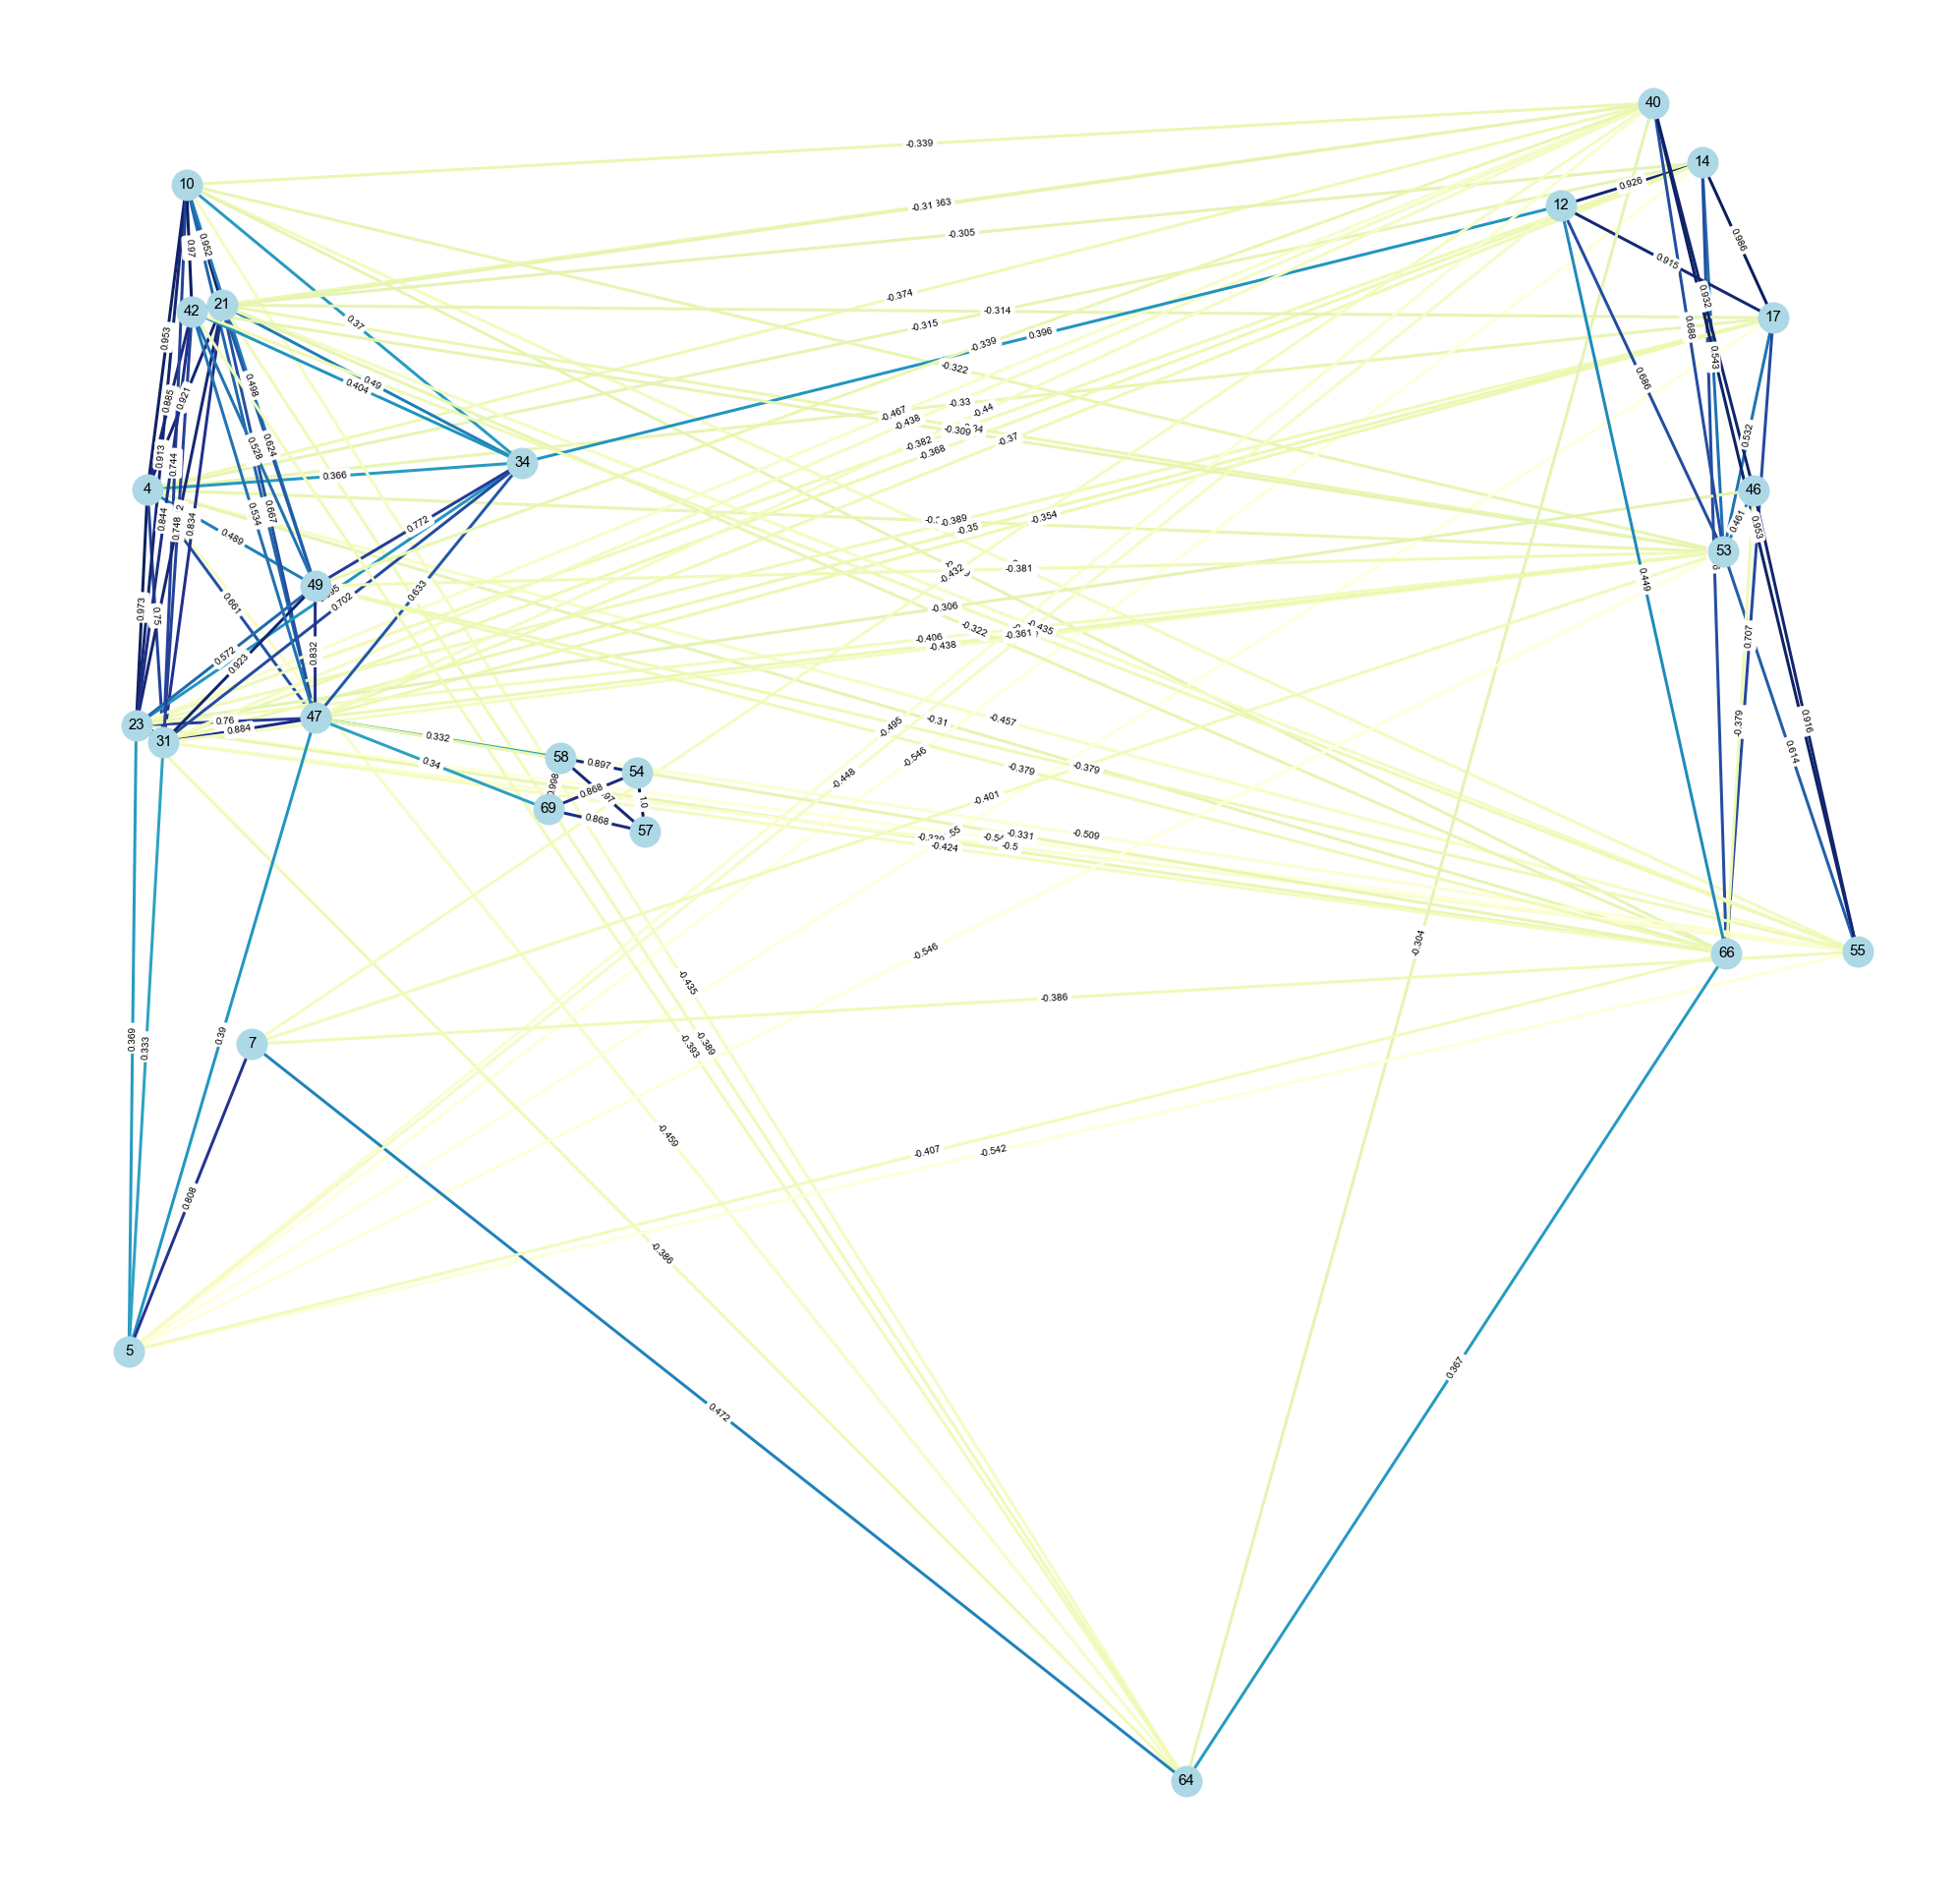

In [20]:
G = nx.Graph()

# G.add_nodes_from(cell_transients_dataframe.columns)

corr_pairs = au.find_correlated_pairs(cell_transients_dataframe.loc[1:40, :], correlation_coeff=0.3)

for key in corr_pairs:
    G.add_edge(key[0], key[1], weight=round(corr_pairs[key], 3))
    
# positions for all nodes
pos = nx.spring_layout(G, weight='weight') 

plt.figure(figsize=(35, 35))

# nodes
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue');

edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

# edges
nx.draw_networkx_edges(G, pos, width=3.0, edge_color=weights, edge_cmap=plt.cm.YlGnBu);

labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# labels
nx.draw_networkx_labels(G, pos, font_size=15, edge_labels=labels)

plt.axis('off');
plt.show();

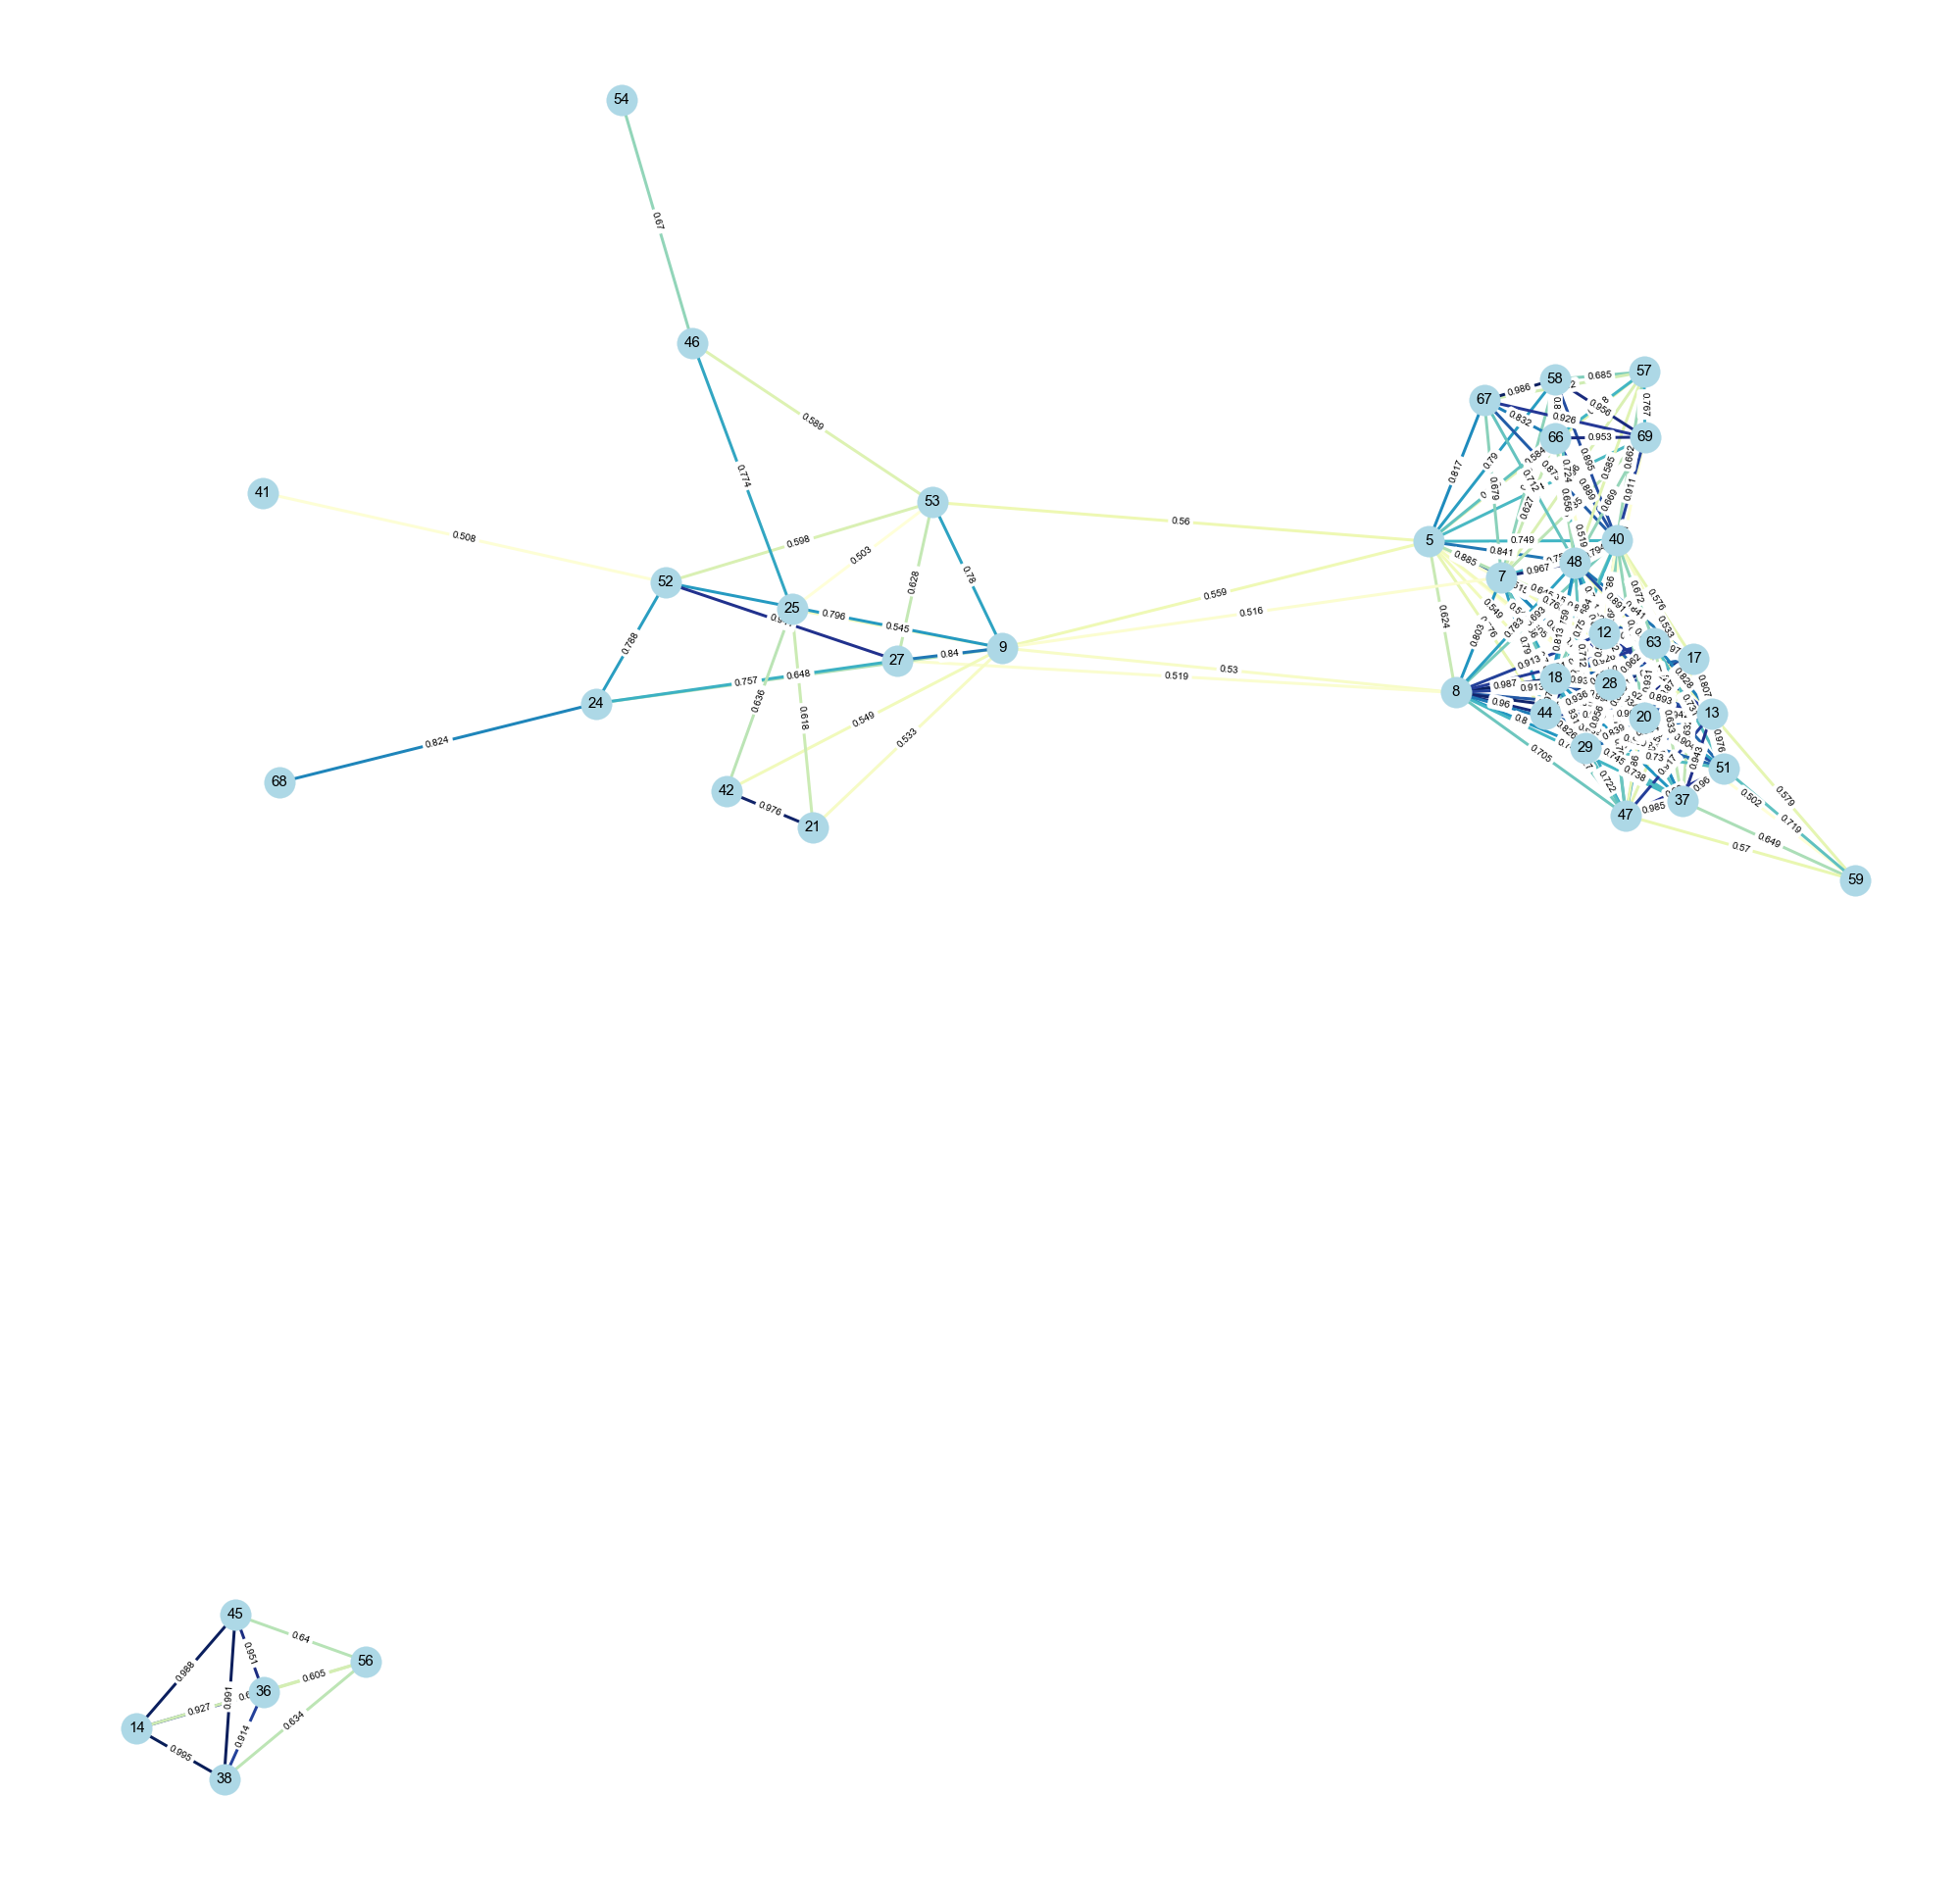

In [21]:
G = nx.Graph()

# G.add_nodes_from(cell_transients_dataframe.columns)

corr_pairs = au.find_correlated_pairs(cell_transients_dataframe.loc[537:642, :], correlation_coeff=0.5)

for key in corr_pairs:
    G.add_edge(key[0], key[1], weight=round(corr_pairs[key], 3))
    
# positions for all nodes
pos = nx.spring_layout(G, k=0.2, weight='weight') 

plt.figure(figsize=(35, 35))

# nodes
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue');

edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

# edges
nx.draw_networkx_edges(G, pos, width=3.0, edge_color=weights, edge_cmap=plt.cm.YlGnBu);

labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# labels
nx.draw_networkx_labels(G, pos, font_size=15, edge_labels=labels)

plt.axis('off');
plt.show();

## Interpretation of network measures & further analysis
- Plotting assortativity 
- Plotting the network for different activities, e.g. What did this network of neurons look like when the mouse was doing some behavior, $b$
- Generating network plots of the data over time, e.g. network looked like that during first 2 minute interval, like this during second 2 minute interval, and etc.
- Plotting the network, but preserving the positions of the nodes (neurons) as they looked in the video